In [1]:
import os
import pandas as pd
import numpy as np
from os import listdir
from tqdm import tqdm  # For progress bars
import re
import logging

In [2]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("data_collection.log"),
        logging.StreamHandler()
    ]
)

In [3]:
# Define your base path
base_path = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"

# Verify that the base_path exists
if not os.path.exists(base_path):
    logging.error(f"The base path {base_path} does not exist.")
    raise FileNotFoundError(f"The base path {base_path} does not exist.")
else:
    logging.info(f"Base path {base_path} found.")

In [4]:
# List all patient folders
patient_folders = [f for f in listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

logging.info(f"Total patients found: {len(patient_folders)}")

In [5]:
def parse_filename(filename):
    """
    Parses the filename to extract patient_id, x, y, and class.
    
    Expected format: patientID_xX_yY_classC.png
    Example: 10253_idx5_x1351_y1101_class0.png
    
    Returns a dictionary with keys: patient_id, x, y, class
    """
    pattern = r'(?P<patient_id>[^_]+_[^_]+)_x(?P<x>\d+)_y(?P<y>\d+)_class(?P<class>[01]).png$'
    match = re.match(pattern, filename)
    if match:
        return match.groupdict()
    else:
        logging.warning(f"Filename does not match expected format: {filename}")
        return {'patient_id': None, 'x': None, 'y': None, 'class': None}


In [6]:
# Initialize a list to store data
data_records = []

# Iterate through each patient with a progress bar
for patient in tqdm(patient_folders, desc="Processing Patients"):
    patient_path = os.path.join(base_path, patient)
    
    # Iterate through each class folder (0 and 1)
    for class_label in ['0', '1']:
        class_path = os.path.join(patient_path, class_label)
        
        # Check if the class_path exists
        if not os.path.exists(class_path):
            logging.warning(f"Class path {class_path} does not exist for patient {patient}. Skipping.")
            continue
        
        # List all image files in the class directory
        try:
            image_files = [f for f in listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        except Exception as e:
            logging.error(f"Error accessing files in {class_path}: {e}")
            continue
        
        # Iterate through each image file
        for image_file in image_files:
            # Parse the filename to extract information
            parsed = parse_filename(image_file)
            
            # If parsing failed, skip this file
            if parsed['patient_id'] is None:
                continue
            
            # Construct the full image path
            image_path = os.path.join(class_path, image_file)
            
            # Append the data record
            data_records.append({
                'patient_id': parsed['patient_id'],
                'path': image_path,
                'x': int(parsed['x']),
                'y': int(parsed['y']),
                'class': int(parsed['class'])
            })

logging.info(f"Total images processed: {len(data_records)}")

Processing Patients: 100%|██████████| 279/279 [11:55<00:00,  2.56s/it]


In [7]:
# Create a DataFrame from the collected data
data_df = pd.DataFrame(data_records)

logging.info(f"DataFrame created with shape: {data_df.shape}")

# Display the first few rows
logging.info(f"First 5 entries:\n{data_df.head()}")

In [8]:
# Check for missing values
missing_values = data_df.isnull().sum()
if missing_values.any():
    logging.warning("Missing values detected in the DataFrame:")
    logging.warning(f"\n{missing_values}")
else:
    logging.info("No missing values detected in the DataFrame.")


In [9]:
# Check data types
logging.info(f"Data types before conversion:\n{data_df.dtypes}")

# Convert data types if necessary
data_df['x'] = data_df['x'].astype(int)
data_df['y'] = data_df['y'].astype(int)
data_df['class'] = data_df['class'].astype(int)

logging.info("Data types after conversion:")
logging.info(f"{data_df.dtypes}")


In [10]:
# Extract patient_id from the DataFrame and compare with the folder
inconsistent_ids = data_df[data_df['patient_id'] != data_df['patient_id']]

if inconsistent_ids.empty:
    logging.info("All patient IDs are consistent.")
else:
    logging.warning("Inconsistent patient IDs found:")
    logging.warning(f"\n{inconsistent_ids}")


In [11]:
# Check unique class labels
unique_classes = data_df['class'].unique()
logging.info(f"Unique class labels: {unique_classes}")

# Ensure only classes 0 and 1 are present
if set(unique_classes).issubset({0, 1}):
    logging.info("All class labels are valid (0 and 1).")
else:
    logging.warning("Unexpected class labels detected:")
    logging.warning(f"Classes found: {unique_classes}")


In [12]:
# Check for duplicate image paths
duplicate_paths = data_df.duplicated(subset=['path']).sum()
if duplicate_paths > 0:
    logging.warning(f"Found {duplicate_paths} duplicate image paths.")
    # Optionally, remove duplicates
    data_df = data_df.drop_duplicates(subset=['path'])
    logging.info(f"Duplicates removed. New DataFrame shape: {data_df.shape}")
else:
    logging.info("No duplicate image paths found.")


In [13]:
# Define the output CSV path
output_csv = "breast_histopathology_dataset.csv"

# Save the DataFrame to CSV
data_df.to_csv(output_csv, index=False)

logging.info(f"DataFrame successfully saved to {output_csv}")


In [14]:
# Load the CSV to verify
loaded_df = pd.read_csv(output_csv)

# Display the first few rows
logging.info(f"First 5 entries from the loaded CSV:\n{loaded_df.head()}")

# Verify the shape matches
if loaded_df.shape == data_df.shape:
    logging.info("Loaded CSV shape matches the original DataFrame.")
else:
    logging.warning("Loaded CSV shape does not match the original DataFrame.")


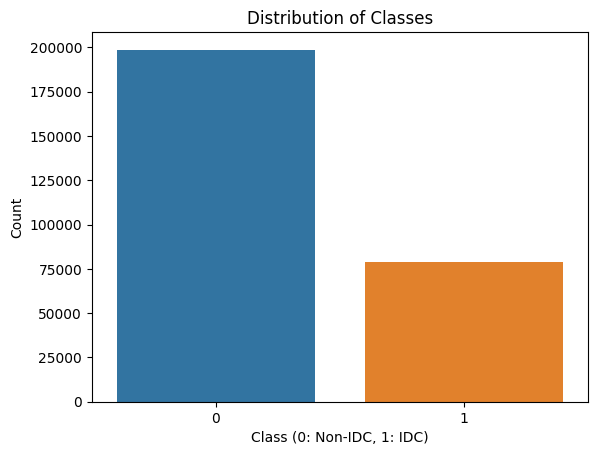

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


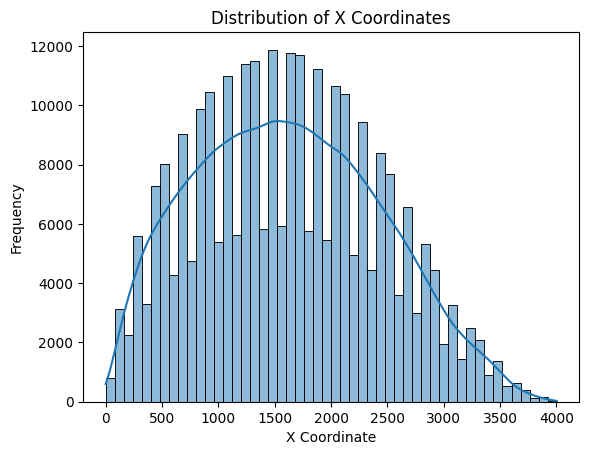

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


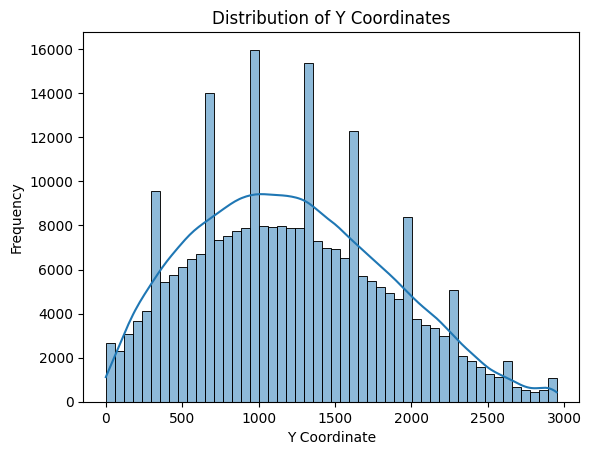

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Classes
sns.countplot(x='class', data=data_df)
plt.title("Distribution of Classes")
plt.xlabel("Class (0: Non-IDC, 1: IDC)")
plt.ylabel("Count")
plt.show()

# Distribution of X Coordinates
sns.histplot(data=data_df, x='x', bins=50, kde=True)
plt.title("Distribution of X Coordinates")
plt.xlabel("X Coordinate")
plt.ylabel("Frequency")
plt.show()

# Distribution of Y Coordinates
sns.histplot(data=data_df, x='y', bins=50, kde=True)
plt.title("Distribution of Y Coordinates")
plt.xlabel("Y Coordinate")
plt.ylabel("Frequency")
plt.show()


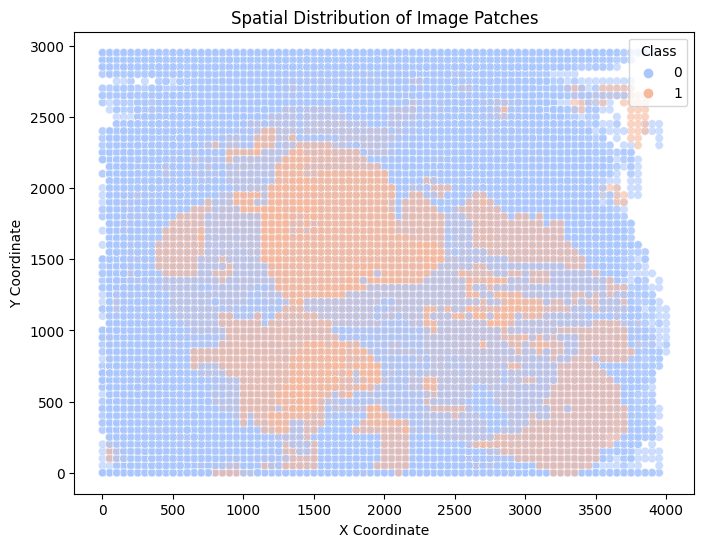

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='x', y='y', hue='class', data=data_df, palette='coolwarm', alpha=0.6)
plt.title("Spatial Distribution of Image Patches")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(title='Class', loc='upper right')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x600 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


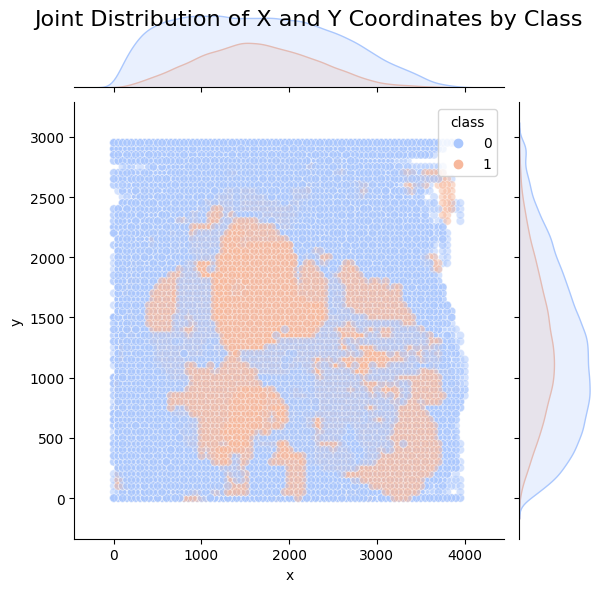

In [17]:
plt.figure(figsize=(8,6))
sns.jointplot(x='x', y='y', hue='class', data=data_df, palette='coolwarm', alpha=0.5)
plt.suptitle("Joint Distribution of X and Y Coordinates by Class", fontsize=16)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


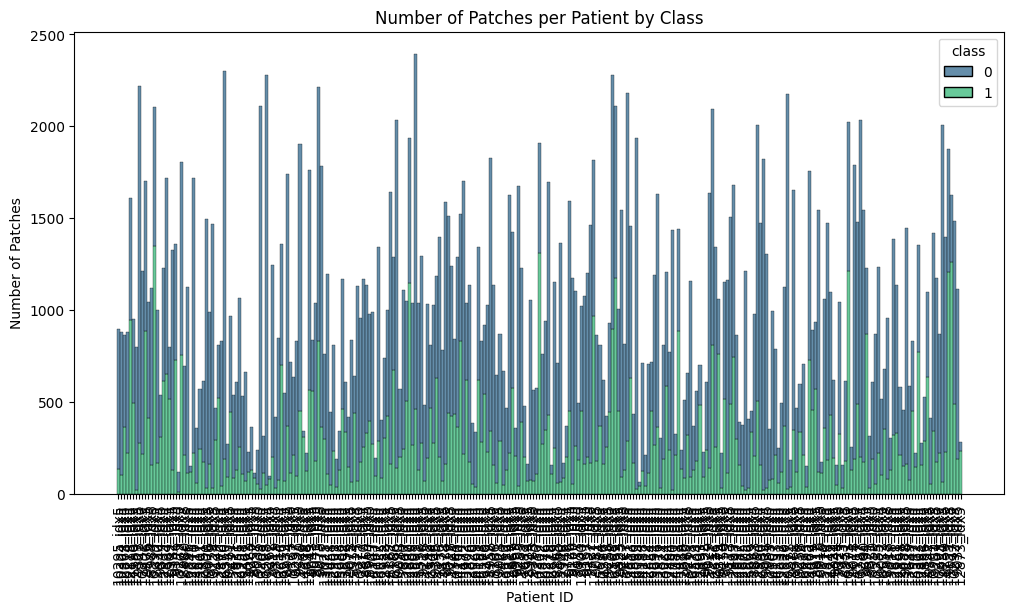

In [18]:
plt.figure(figsize=(12,6))
sns.histplot(data=data_df, x='patient_id', hue='class', multiple='stack', palette='viridis', bins=30)
plt.xticks(rotation=90)
plt.title("Number of Patches per Patient by Class")
plt.xlabel("Patient ID")
plt.ylabel("Number of Patches")
plt.show()


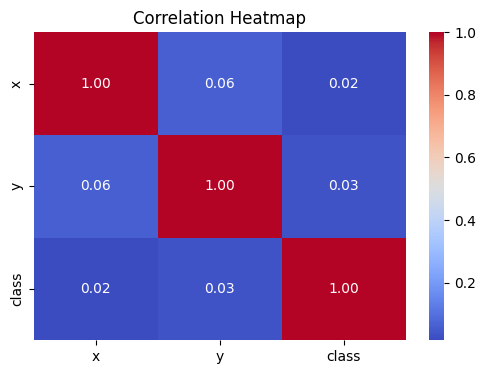

In [19]:
# Compute the correlation matrix
corr = data_df[['x', 'y', 'class']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


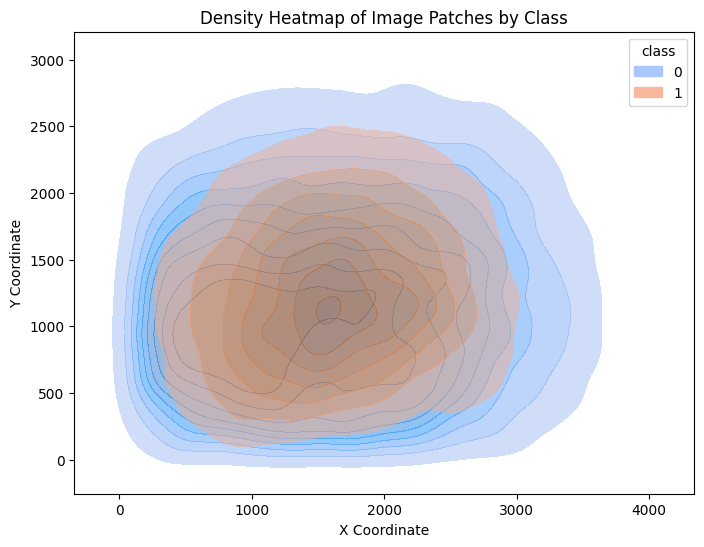

In [20]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=data_df, x='x', y='y', hue='class', fill=True, palette='coolwarm', alpha=0.5)
plt.title("Density Heatmap of Image Patches by Class")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


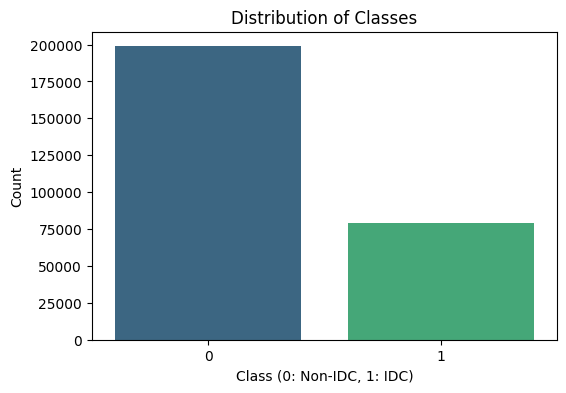

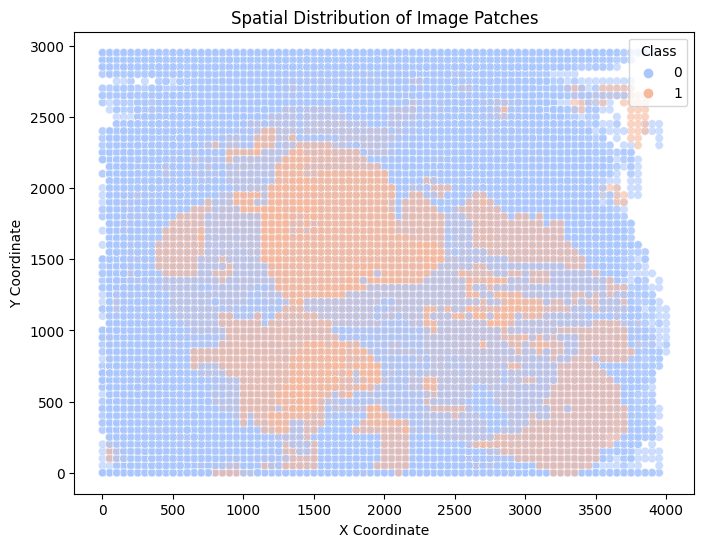

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x600 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


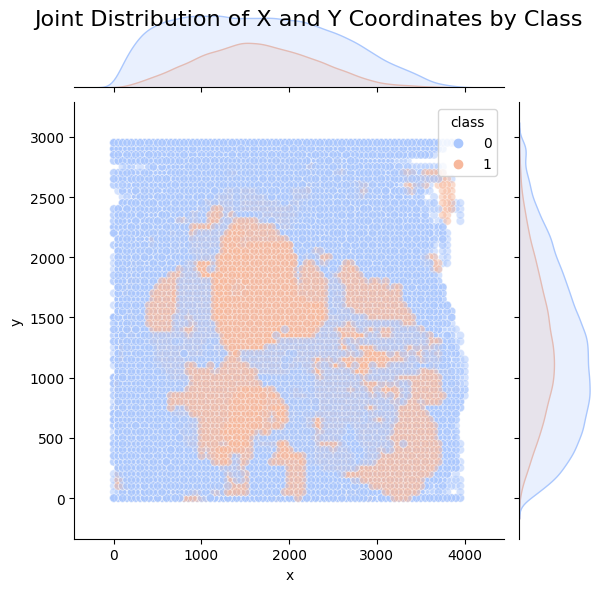

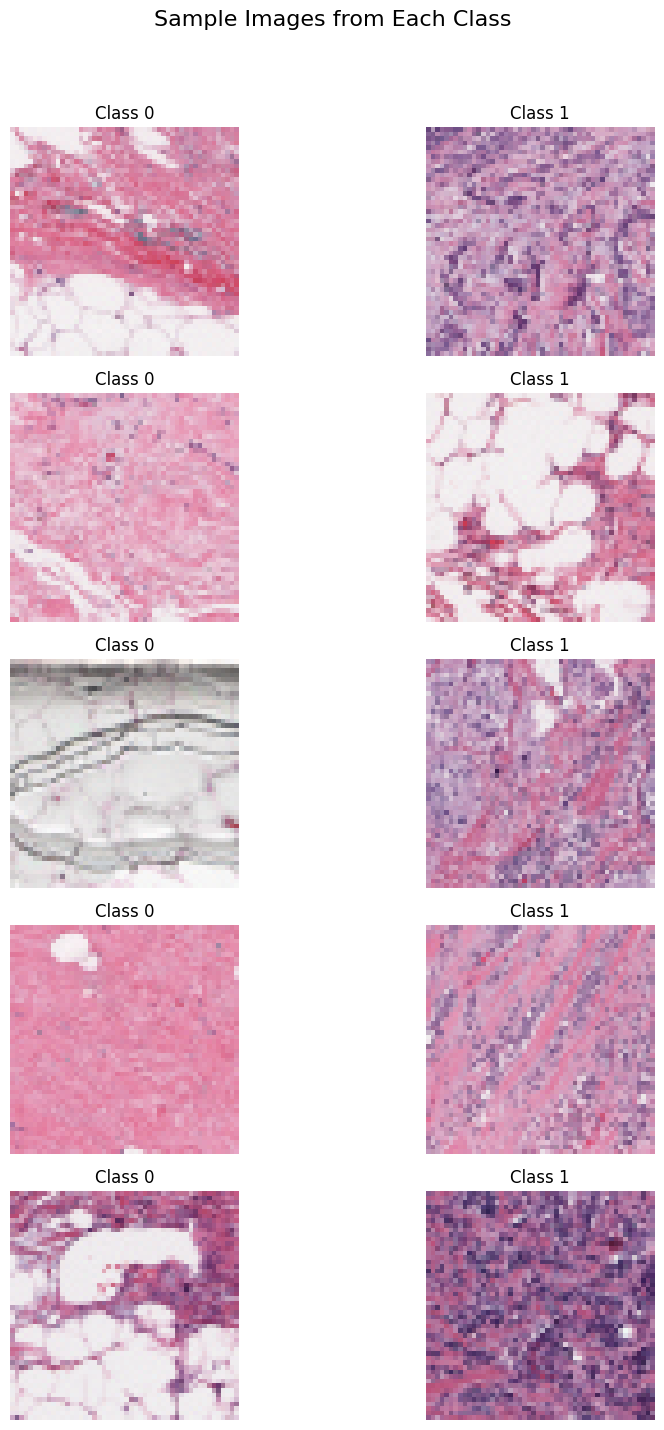

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


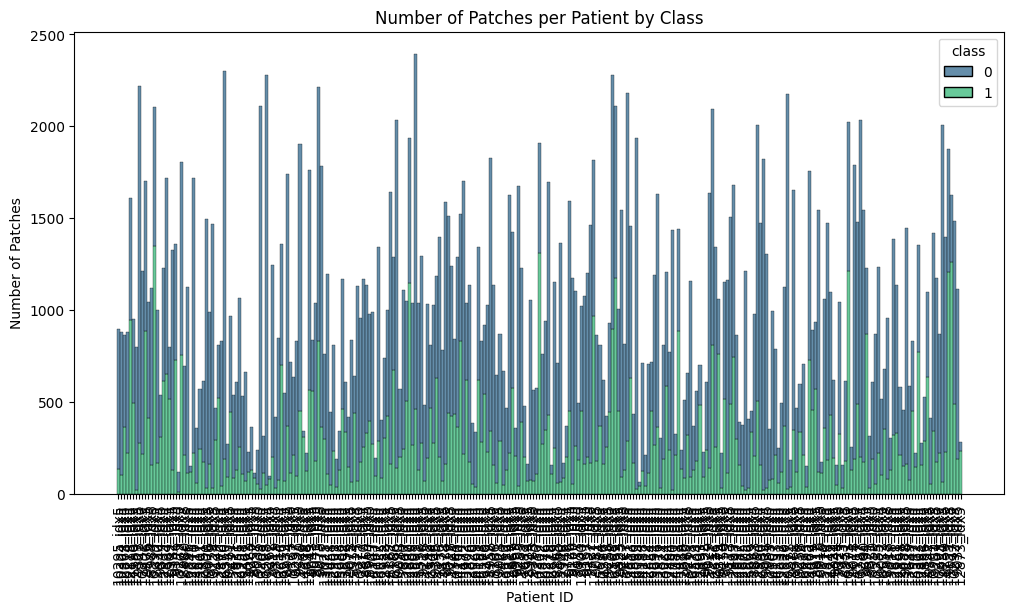

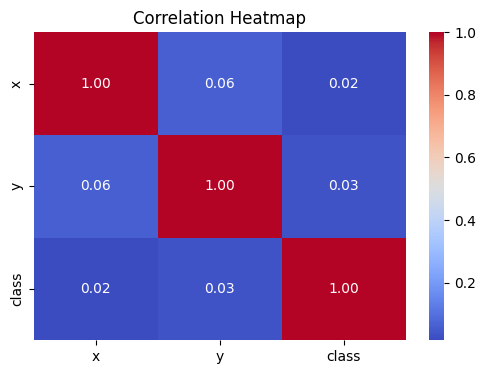

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


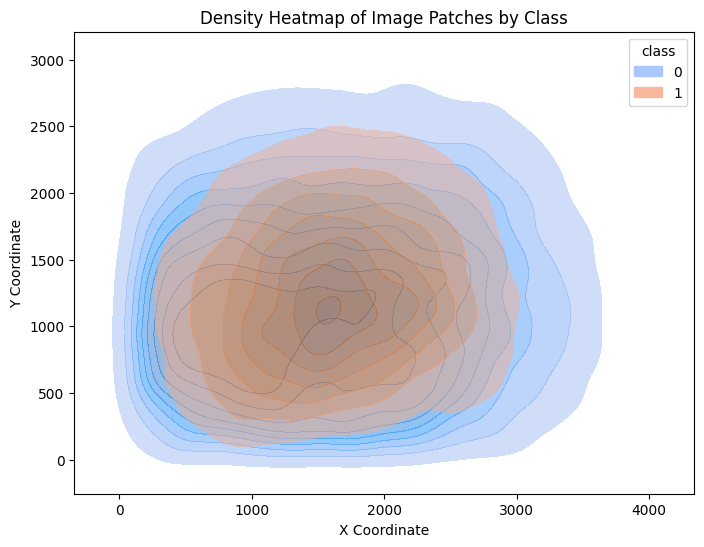

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import plotly.express as px

# Assuming 'data_df' is your DataFrame
# If not, load it:
# data_df = pd.read_csv('breast_histopathology_dataset.csv')

# 1. Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=data_df, palette='viridis')
plt.title("Distribution of Classes")
plt.xlabel("Class (0: Non-IDC, 1: IDC)")
plt.ylabel("Count")
plt.show()

# 2. Spatial Distribution of Image Patches
plt.figure(figsize=(8,6))
sns.scatterplot(x='x', y='y', hue='class', data=data_df, palette='coolwarm', alpha=0.6)
plt.title("Spatial Distribution of Image Patches")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(title='Class', loc='upper right')
plt.show()

plt.figure(figsize=(8,6))
sns.jointplot(x='x', y='y', hue='class', data=data_df, palette='coolwarm', alpha=0.5)
plt.suptitle("Joint Distribution of X and Y Coordinates by Class", fontsize=16)
plt.show()

# 3. Sample Images from Each Class
import math

"""samples_per_class = 5
unique_classes = data_df['class'].unique()

fig, axes = plt.subplots(samples_per_class, len(unique_classes), figsize=(10, 15))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for cls in unique_classes:
    cls_df = data_df[data_df['class'] == cls]
    samples = cls_df.sample(n=samples_per_class, random_state=42)
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        img = Image.open(row['path'])
        ax = axes[i, cls]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Class {cls}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()"""



# 4. Number of Patches per Patient
plt.figure(figsize=(12,6))
sns.histplot(data=data_df, x='patient_id', hue='class', multiple='stack', palette='viridis', bins=30)
plt.xticks(rotation=90)
plt.title("Number of Patches per Patient by Class")
plt.xlabel("Patient ID")
plt.ylabel("Number of Patches")
plt.show()

# 5. Correlation Heatmap
corr = data_df[['x', 'y', 'class']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 6. Density Heatmap of Patches
plt.figure(figsize=(8,6))
sns.kdeplot(data=data_df, x='x', y='y', hue='class', fill=True, palette='coolwarm', alpha=0.5)
plt.title("Density Heatmap of Image Patches by Class")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()





# 8. Interactive Visualizations with Plotly
fig = px.scatter(
    data_df,
    x='x',
    y='y',
    color='class',
    title='Interactive Scatter Plot of Image Patches',
    labels={'x': 'X Coordinate', 'y': 'Y Coordinate', 'class': 'Class'},
    hover_data=['patient_id', 'path']
)

fig.show()

fig = px.density_heatmap(
    data_df,
    x='x',
    y='y',
    z='class',
    histfunc='avg',
    nbinsx=50,
    nbinsy=50,
    title='Interactive Density Heatmap of Image Patches',
    labels={'x': 'X Coordinate', 'y': 'Y Coordinate', 'z': 'Average Class'}
)

fig.show()

# 9. Additional Visualizations

# a. Box Plots for Coordinates by Class
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x='class', y='x', data=data_df, palette='Set2')
plt.title("Box Plot of X Coordinates by Class")
plt.xlabel("Class")
plt.ylabel("X Coordinate")

plt.subplot(1,2,2)
sns.boxplot(x='class', y='y', data=data_df, palette='Set1')
plt.title("Box Plot of Y Coordinates by Class")
plt.xlabel("Class")
plt.ylabel("Y Coordinate")

plt.tight_layout()
plt.show()

# b. Violin Plots for Coordinates by Class
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.violinplot(x='class', y='x', data=data_df, palette='Pastel1')
plt.title("Violin Plot of X Coordinates by Class")
plt.xlabel("Class")
plt.ylabel("X Coordinate")

plt.subplot(1,2,2)
sns.violinplot(x='class', y='y', data=data_df, palette='Pastel2')
plt.title("Violin Plot of Y Coordinates by Class")
plt.xlabel("Class")
plt.ylabel("Y Coordinate")

plt.tight_layout()
plt.show()

# c. Facet Grid of Classes
g = sns.FacetGrid(data_df, col='class', height=5, aspect=1)
g.map(sns.scatterplot, 'x', 'y', alpha=0.6, palette='coolwarm')
g.add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Facet Grid of Image Patches by Class')
plt.show()

# d. Histogram of Patches per Patient
patches_per_patient = data_df['patient_id'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(patches_per_patient, bins=50, kde=True, color='skyblue')
plt.title("Histogram of Number of Patches per Patient")
plt.xlabel("Number of Patches")
plt.ylabel("Number of Patients")
plt.show()

# e. Pair Plot
sns.pairplot(data_df, vars=['x', 'y'], hue='class', palette='coolwarm', diag_kind='kde')
plt.suptitle("Pair Plot of Coordinates by Class", y=1.02)
plt.show()


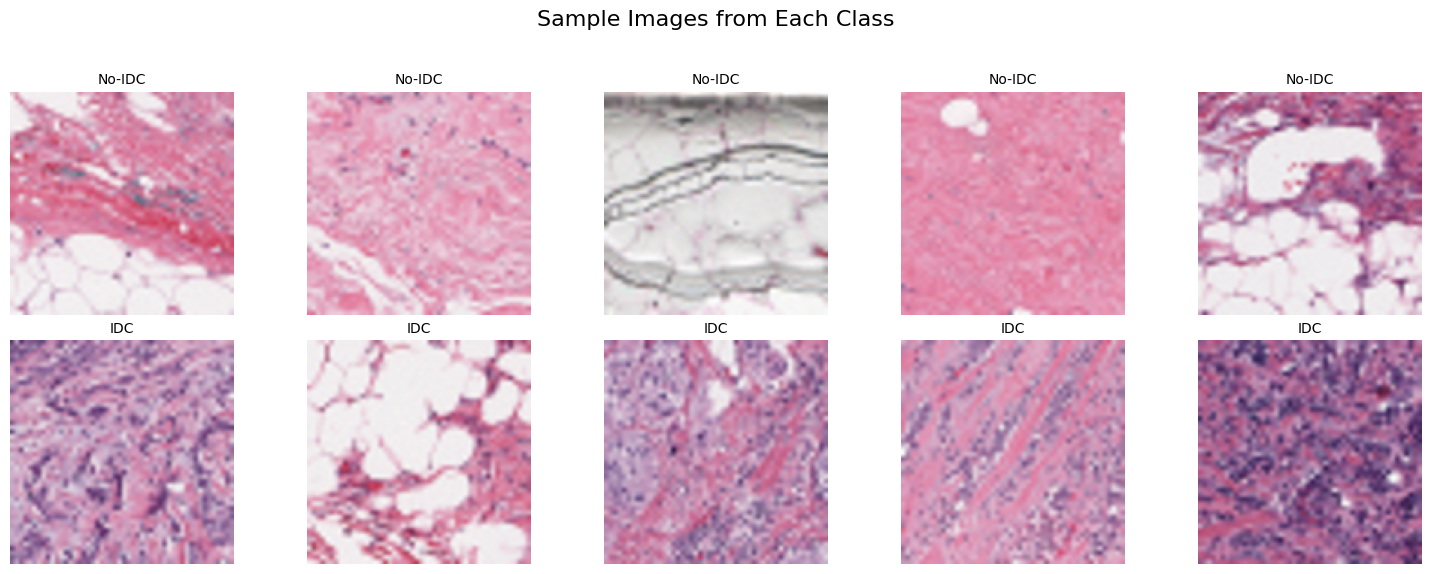

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
import math

# Parameters
samples_per_class = 5
unique_classes = data_df['class'].unique()
num_classes = len(unique_classes)

# Define the class name mapping
class_name_mapping = {
    0: "No-IDC",
    1: "IDC"
    # Add more mappings here if you have additional classes
}

# Verify that all classes have a corresponding name in the mapping
missing_classes = set(unique_classes) - set(class_name_mapping.keys())
if missing_classes:
    raise ValueError(f"Missing class names for classes: {missing_classes}")

# Create subplots: one row per class, one column per sample
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
fig.suptitle('Sample Images from Each Class', fontsize=16)

# Ensure axes is a 2D array even if there's only one row or column
if num_classes == 1:
    axes = [axes]
if samples_per_class == 1:
    axes = [[ax] for ax in axes]

for class_idx, cls in enumerate(unique_classes):
    cls_df = data_df[data_df['class'] == cls]
    samples = cls_df.sample(n=samples_per_class, random_state=42)
    
    for sample_idx, (idx, row) in enumerate(samples.iterrows()):
        try:
            img = Image.open(row['path'])
            # Optional: Resize images for uniformity
            desired_size = (150, 150)  # Adjust as needed
            img = img.resize(desired_size)
            
            ax = axes[class_idx][sample_idx]
            ax.imshow(img)
            ax.axis('off')
            
            # Retrieve the class name from the mapping
            class_name = class_name_mapping.get(cls, f"Class {cls}")
            
            # Set the class name as the title for each image
            ax.set_title(class_name, fontsize=10)
        except Exception as e:
            print(f"Error loading image {row['path']}: {e}")
            axes[class_idx][sample_idx].axis('off')
            axes[class_idx][sample_idx].set_title("Error", fontsize=10)

# Optional: Add borders to each image for better separation
for ax_row in axes:
    for ax in ax_row:
        for spine in ax.spines.values():
            spine.set_visible(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Optional: Save the figure
plt.savefig('sample_images_by_class.png', dpi=300)

plt.show()